In [2]:
# The code was removed by Watson Studio for sharing.

<a href=""><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [3]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-08-11 10:28:05--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.08s   

2020-08-11 10:28:05 (267 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



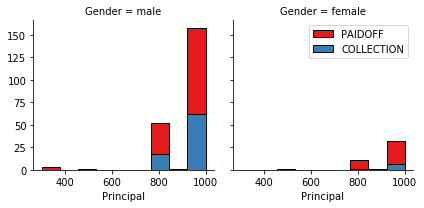

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

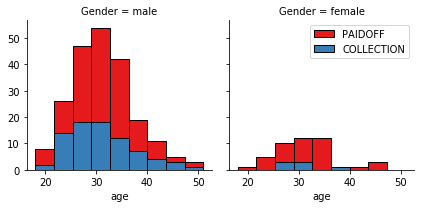

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

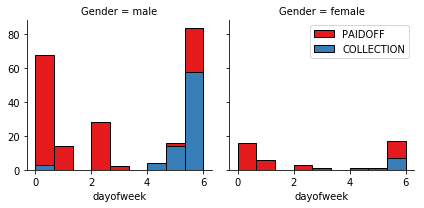

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay their loans while only 73 % of males pay their loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:10]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1
5,1000,30,36,0,1,0,0,1
6,1000,30,28,0,1,0,0,1
7,800,15,26,0,1,0,0,1
8,300,7,29,0,1,0,0,1
9,1000,15,39,0,1,0,1,0


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:10]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [102]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 25
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):   
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat1 = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat1)
    std_acc[n-1]=np.std(yhat1==y_test)/np.sqrt(yhat1.shape[0]) #standard deviation of the mean

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286, 0.67142857,
       0.7       , 0.72857143, 0.7       , 0.7       , 0.68571429,
       0.72857143, 0.72857143, 0.72857143, 0.7       , 0.68571429,
       0.71428571, 0.68571429, 0.7       , 0.7       ])

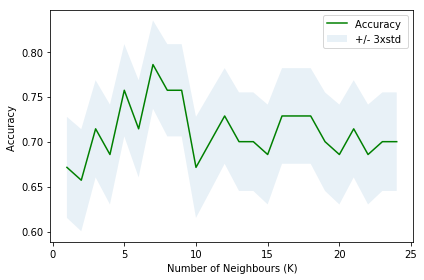

Best accuracy:  0.7857142857142857 with k:  7
F1-score: 
0.7766540244416351
Jaccard: 
0.7857142857142857


In [103]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

k =  mean_acc.argmax()+1

# Train the model with the full train dataset and selected parameters
neigh = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
yhat1 = neigh.predict(X_test)

# F1-score and Jaccard score
f1 = f1_score(y_test, yhat1, average='weighted')
jacc = jaccard_similarity_score(y_test, yhat1)
print( 'Best accuracy: ', mean_acc.max(), 'with k: ', k)
print( 'F1-score: ', f1, 'Jaccard: ', jacc, sep='\n')

# Decision Tree

In [104]:
from sklearn.tree import DecisionTreeClassifier

In [105]:
scores = []
criterion = []
counter = 0
for crit in ['gini','entropy']:
    for depth in range(1,20):
        DecisionTree = DecisionTreeClassifier(criterion=crit, max_depth=depth).fit(X_train,y_train)
        yhat2 = DecisionTree.predict(X_test)
        accuracy = metrics.accuracy_score(y_test,yhat2)
        print('Test {}: Accuracy at criterion = {} when max_depth = {} is : {}'.format(counter, crit, depth, accuracy))
        scores.append(accuracy)
        criterion.append(crit)
        counter += 1
        

Test 0: Accuracy at criterion = gini when max_depth = 1 is : 0.7857142857142857
Test 1: Accuracy at criterion = gini when max_depth = 2 is : 0.7857142857142857
Test 2: Accuracy at criterion = gini when max_depth = 3 is : 0.6142857142857143
Test 3: Accuracy at criterion = gini when max_depth = 4 is : 0.6142857142857143
Test 4: Accuracy at criterion = gini when max_depth = 5 is : 0.6285714285714286
Test 5: Accuracy at criterion = gini when max_depth = 6 is : 0.7714285714285715
Test 6: Accuracy at criterion = gini when max_depth = 7 is : 0.7571428571428571
Test 7: Accuracy at criterion = gini when max_depth = 8 is : 0.7285714285714285
Test 8: Accuracy at criterion = gini when max_depth = 9 is : 0.6428571428571429
Test 9: Accuracy at criterion = gini when max_depth = 10 is : 0.7142857142857143
Test 10: Accuracy at criterion = gini when max_depth = 11 is : 0.7
Test 11: Accuracy at criterion = gini when max_depth = 12 is : 0.7142857142857143
Test 12: Accuracy at criterion = gini when max_dep

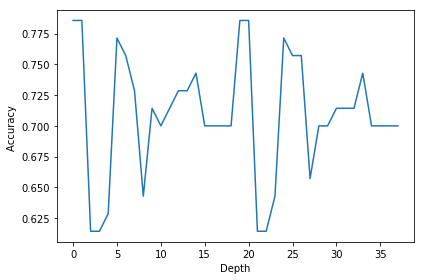

Optimal depth: 1  Maximum accuracy:  0.7857142857142857  Criterion:  gini
F1-score: 
0.6914285714285714
Jaccard: 
0.7857142857142857


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [106]:
plt.plot(scores)
plt.ylabel('Accuracy ')
plt.xlabel('Depth')
plt.tight_layout()
plt.show()

optim_depth = scores.index(max(scores)) +1
criterion
optim_crit = criterion[scores.index(max(scores))]
print('Optimal depth:', optim_depth, ' Maximum accuracy: ', scores[scores.index(max(scores))], ' Criterion: ', optim_crit)

# Train the model with the selected parameters
DecisionTree = DecisionTreeClassifier(criterion=optim_crit, max_depth=optim_depth).fit(X_train,y_train)
yhat2 = DecisionTree.predict(X_test)

# F1-score and Jaccard score
f1 = f1_score(y_test, yhat2, average='weighted')
jacc = jaccard_similarity_score(y_test, yhat2)
print( 'F1-score: ', f1, 'Jaccard: ', jacc, sep='\n')

# Support Vector Machine

In [107]:
from sklearn import svm
from sklearn.metrics import f1_score

In [108]:
scores = []
kernel_list = []
C_list = []
counter = 0
for kernel in ['sigmoid', 'poly', 'rbf', 'linear']:
    for C in [1.0,0.5,0.1,0.05,0.01,0.005,0.001]:
        SVM = svm.SVC(C = C, gamma = 'auto', kernel = kernel).fit(X_train,y_train)
        yhat3 = SVM.predict(X_test)
        f1 = metrics.f1_score(y_test,yhat3, average = 'weighted')
        print('Test: {} C: {} kernel: {} Accuracy: {}'.format(counter, counter, kernel, f1 ))
        scores.append(f1)
        kernel_list.append(kernel)
        C_list.append(C)
        counter += 1

Test: 0 C: 0 kernel: sigmoid Accuracy: 0.6892857142857144
Test: 1 C: 1 kernel: sigmoid Accuracy: 0.6914285714285714
Test: 2 C: 2 kernel: sigmoid Accuracy: 0.6914285714285714
Test: 3 C: 3 kernel: sigmoid Accuracy: 0.6914285714285714
Test: 4 C: 4 kernel: sigmoid Accuracy: 0.6914285714285714
Test: 5 C: 5 kernel: sigmoid Accuracy: 0.6914285714285714
Test: 6 C: 6 kernel: sigmoid Accuracy: 0.6914285714285714
Test: 7 C: 7 kernel: poly Accuracy: 0.7064793130366899
Test: 8 C: 8 kernel: poly Accuracy: 0.6843317972350231
Test: 9 C: 9 kernel: poly Accuracy: 0.6914285714285714
Test: 10 C: 10 kernel: poly Accuracy: 0.6914285714285714
Test: 11 C: 11 kernel: poly Accuracy: 0.6914285714285714
Test: 12 C: 12 kernel: poly Accuracy: 0.6914285714285714
Test: 13 C: 13 kernel: poly Accuracy: 0.6914285714285714
Test: 14 C: 14 kernel: rbf Accuracy: 0.7275882012724117
Test: 15 C: 15 kernel: rbf Accuracy: 0.6914285714285714
Test: 16 C: 16 kernel: rbf Accuracy: 0.6914285714285714
Test: 17 C: 17 kernel: rbf Accura

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Pyth

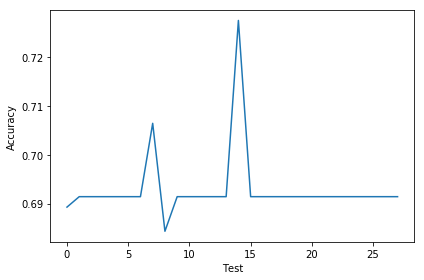

In [109]:
plt.plot(scores)
plt.ylabel('Accuracy')
plt.xlabel('Test')
plt.tight_layout()
plt.show()

In [110]:
max_accuracy = max(scores)
i = scores.index(max(scores))
kernel_optim = kernel_list[i]
C_optim = C_list[i]
print('Test:',i,' Max accuracy: ', max_accuracy, 'Kernel:', kernel_optim, 'C:', C_optim)

# Train the model with the selected parameters
SVM = svm.SVC(C = C_optim, gamma = 'auto', kernel = kernel_optim).fit(X_train,y_train)
yhat3 = SVM.predict(X_test)

# F1-score and Jaccard score
f1 = f1_score(y_test, yhat3, average='weighted')
jacc = jaccard_similarity_score(y_test, yhat3)
print( 'F1-score: ', f1, 'Jaccard: ', jacc, sep='\n')

Test: 14  Max accuracy:  0.7275882012724117 Kernel: rbf C: 1.0
F1-score: 
0.7275882012724117
Jaccard: 
0.7428571428571429


# Logistic Regression

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [112]:
scores = []
C_list = []
solver_list = []
counter = 0
for solver in ['lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag']:
    for C in [0.1, 0.01, 0.001]:
        LR = LogisticRegression(C=C, solver=solver).fit(X_train,y_train)
        yhat4 = LR.predict(X_test)
        y_prob = LR.predict_proba(X_test)
        logLoss = metrics.log_loss(y_test, y_prob)
        print('Test: {} Solver: {} C: {} Accuracy: {}'.format(counter, solver, C, logLoss ))
        scores.append(logLoss)
        C_list.append(C)
        solver_list.append(solver)
        counter += 1

Test: 0 Solver: lbfgs C: 0.1 Accuracy: 0.4827539604894662
Test: 1 Solver: lbfgs C: 0.01 Accuracy: 0.4920179847937498
Test: 2 Solver: lbfgs C: 0.001 Accuracy: 0.5181766145124602
Test: 3 Solver: saga C: 0.1 Accuracy: 0.4827547452047885
Test: 4 Solver: saga C: 0.01 Accuracy: 0.49202381079864527
Test: 5 Solver: saga C: 0.001 Accuracy: 0.5181758695279358
Test: 6 Solver: liblinear C: 0.1 Accuracy: 0.4981902487744225
Test: 7 Solver: liblinear C: 0.01 Accuracy: 0.5772287609479654
Test: 8 Solver: liblinear C: 0.001 Accuracy: 0.670867975563743
Test: 9 Solver: newton-cg C: 0.1 Accuracy: 0.48275353245267294
Test: 10 Solver: newton-cg C: 0.01 Accuracy: 0.4920178014679269
Test: 11 Solver: newton-cg C: 0.001 Accuracy: 0.5181765961927621
Test: 12 Solver: sag C: 0.1 Accuracy: 0.48275264662451034
Test: 13 Solver: sag C: 0.01 Accuracy: 0.4920173392240046
Test: 14 Solver: sag C: 0.001 Accuracy: 0.5181634712148898


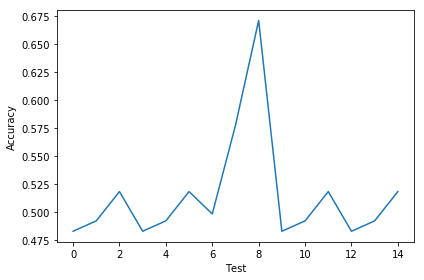

In [113]:
plt.plot(scores)
plt.ylabel('Accuracy')
plt.xlabel('Test')
plt.tight_layout()
plt.show()

In [114]:
max_accuracy = max(scores)
i = scores.index(max(scores))
solver_optim = solver_list[i]
C_optim = C_list[i]

print('Test:',i,' Max accuracy: ', max_accuracy, 'Kernel:', kernel_optim, 'C:', C_optim)

# Train the model with the full train dataset and selected parameters
LR = LogisticRegression(C=C_optim, solver=solver_optim).fit(X_train,y_train)
yhat4 = LR.predict(X_test)
y_prob = LR.predict_proba(X_test)
logLoss = metrics.log_loss(y_test, y_prob)

# F1-score and Jaccard score
f1 = f1_score(y_test, yhat4, average='weighted')
jacc = jaccard_similarity_score(y_test, yhat4)
print( 'F1-score: ', f1, 'Jaccard: ', jacc, 'LogLoss:',  logLoss, sep='\n')

Test: 8  Max accuracy:  0.670867975563743 Kernel: rbf C: 0.001
F1-score: 
0.6752209022111361
Jaccard: 
0.6714285714285714
LogLoss:
0.670867975563743


# Model Evaluation using Test set

In [115]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [116]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-08-11 11:03:56--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-08-11 11:03:56 (344 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [117]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [118]:
#Pre-process test dataset
# Convert time
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
## Convert Categorical features to numerical values
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [119]:
# One Hot Encoding  
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test.head()
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [135]:
X_test1 = Feature_test
y_test1 = test_df['loan_status'].values
X_test1 = preprocessing.StandardScaler().fit(X_test1).transform(X_test1)

#print(X_test[0:5],y_test[0:5], sep='\n')
print(X_test1.shape,y_test1.shape,sep='\n')
X_test1[0:5]

(54, 8)
(54,)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [136]:
f1 = []
jacc = []

In [137]:
# KNN
yhat5 = neigh.predict(X_test1)

jacc_tmp = jaccard_similarity_score(y_test1, yhat5)
f1_tmp = f1_score(y_test1, yhat5, average='weighted')
jacc.append(jacc_tmp)
f1.append(f1_tmp)

print('Jaccard:', jacc_tmp, 'F1-score: ', f1_tmp, sep='\n')

Jaccard:
0.6666666666666666
F1-score: 
0.6328400281888654


In [138]:
# Decision Tree
yhat6 = DecisionTree.predict(X_test1)

jacc_tmp = jaccard_similarity_score(y_test1, yhat6)
f1_tmp = f1_score(y_test1, yhat6, average='weighted')
jacc.append(jacc_tmp)
f1.append(f1_tmp)

print('Jaccard:', jacc_tmp, 'F1-score: ', f1_tmp, sep='\n')

Jaccard:
0.7407407407407407
F1-score: 
0.6304176516942475


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [139]:
# Support Vector Machine
yhat7 = SVM.predict(X_test1)

jacc_tmp = jaccard_similarity_score(y_test1, yhat7)
f1_tmp = f1_score(y_test1, yhat7, average='weighted')
jacc.append(jacc_tmp)
f1.append(f1_tmp)

print('Jaccard:', jacc_tmp, 'F1-score: ', f1_tmp, sep='\n')

Jaccard:
0.7962962962962963
F1-score: 
0.7583503077293734


In [140]:
# Logistic Regression
yhat8 = LR.predict(X_test1)
yhat_prob1 = LR.predict_proba(X_test1)

logLoss_tmp = log_loss(y_test1, yhat_prob1)

jacc_tmp = jaccard_similarity_score(y_test1, yhat8)
f1_tmp = f1_score(y_test1, yhat8, average='weighted')
jacc.append(jacc_tmp)
f1.append(f1_tmp)
logLoss = np.full(4, np.nan)
logLoss[len(logLoss)-1] = logLoss_tmp

print('Jaccard:', jacc_tmp, 'F1-score: ', f1_tmp, 'LogLoss:', logLoss_tmp, sep='\n')

Jaccard:
0.7407407407407407
F1-score: 
0.7006734006734008
LogLoss:
0.6689823444409484


# Report Table

In [141]:
from IPython.display import display
df = pd.DataFrame()
df['Algorithm'] = ['KNN','Decision Tree','SVM','Logistic Regression']
df['Jaccard'] = jacc
df['F1-score'] = f1
df['LogLoss'] = logLoss
display(df.round(decimals=3))

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.667,0.633,NaN
1,Decision Tree,0.741,0.630,NaN
2,SVM,0.796,0.758,NaN
3,Logistic Regression,0.741,0.701,0.669


## I choose SVM because it presents higher Jaccar and F1 scores

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>